# Rank Sum Test

The t-test is valid only when the data within each group (for independent samples t-test) or the pairwise differences (for paired samples t-test) are Normally distributed

As we have seen in the lecture, many real life data distributions are normal, but many others are not.

For non-Normal data we can use non-parametric tests, which do not assume that the data are drawn from a Normal distribution.

### Independent samples

The Mann Whitney U, or Wilcoxon Rank Sum Test is a test for a difference in median between two independent samples. As such it is often considered to be a non-parametric equivalent for the independent samples t-test.

The terms Mann Whitney U and Wilcoxon Rank Sum are used interchangeably in a lot of literature and statistical packages, although technically the Mann Whitney version, which came slightly later, is correct in a greater range of cases. 

The Python function we will use is called Mann-Whitney but you will see the same test elsewhere called Rank Sum or Wilcoxon Rank Sum.

## Set up Python libraries

As usual, run the code cell below to import the relevant Python libraries

In [1]:
# Set-up Python libraries - you need to run this but you don't need to change it
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import pandas as pd
import seaborn as sns
sns.set_theme(style='white')
import statsmodels.api as sm
import statsmodels.formula.api as smf

## Example: motor learning and visualization

A researcher hypothesises that when a person learns a new motor skill, imaginary practice (visualising performing the skill between sessions of actual practice) can enhance learning.

She decides to test the hypothesis by training people to juggle. The participants complete 1-hour juggling practice sessions each day until they can juggle for 2 minutes without dropping a ball. Participants are randomly assigned to one of two groups: The Visualisation Group spend time between sessions visualising juggling, whilst the Standard Group do not.

The researcher records the number of sessions taken to reach criterion (2 min juggling without dropping the ball) for each participant.

Test the hypothesis that visualisation reduces the number of sessions required to reach criterion.

### Inspect the data

The data are provided in a text (.csv) file.

Let's load the data as a Pandas dataframe, and plot them to get a sense for their distribution (is it normal?) and any outliers

In [2]:
# load the data and have a look
juggling=pd.read_csv('https://raw.githubusercontent.com/jillxoreilly/StatsCourseBook_2024/main/data/juggling.csv')
juggling

,Group,SessionsToCriterion
0,Standard,15
1,Standard,14
2,Standard,15
3,Standard,8
4,Standard,7
5,Standard,22
6,Standard,36
7,Standard,19
8,Standard,14
9,Standard,18


Let's plot the data to get an idea of the distribution and check for outliers.

As we saw in the session on plotting, a good choice here will be a KDE plot (to get an estimate of the shape of the distribution) and a rug plot (individual data values as the KDE plot is based on only a small sample)

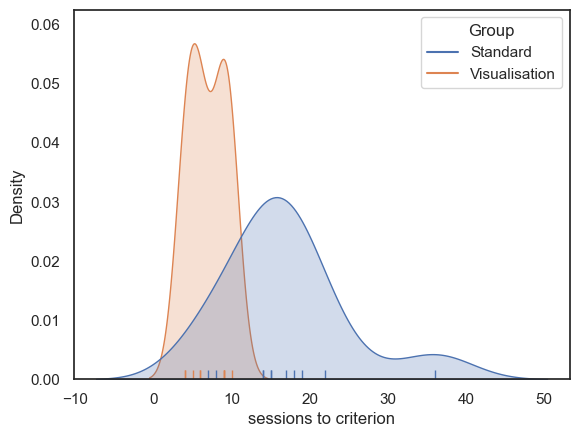

In [3]:
# Plot the KDE (distribution)
sns.kdeplot(data=juggling, x='SessionsToCriterion', hue='Group', fill=True)
sns.rugplot(data=juggling, x='SessionsToCriterion', hue='Group')

# axis labels
plt.xlabel("sessions to criterion", fontsize = 12)
plt.ylabel("Density", fontsize = 12)

plt.show()

Some people (especially in the standard group) took much longer to reach criterion (the distribution has positive skew), perhaps because is possible for an individual to take many many more than the median number of sessions to reach criterion, but impossible to take many many fewer sessions (as we cannot take fewer than zero sessions; data values are <i>bounded below</i>).

We therefore turn to the Rank Sum non-parametric test.

### Hypotheses

Ho: the <b>median</b> number of sessions needed is the same for participants in the Visualisation and Standard Groups

Ha: the <b>median</b> number of sessions is lower for participants in the Visualisation Group
    
This is a one tailed test as the hypothesis is directional (we expect visualisation to help not hinder)

We will test at the $\alpha = 0.05$ significance level

* note we are testing for a difference of medians here, not a difference of means!

### Descriptive statistics

We obtain some relevant descriptive statistics. 

Since we are testing for a difference of medians, we will want the median for each group; it would also be useful to have a measure of spread, and the sample size.

In [4]:
juggling.groupby(['Group']).describe()

SessionsToCriterion                                              \
                            count       mean       std  min   25%   50%   75%   
Group                                                                           
Standard                     11.0  16.818182  7.730694  7.0  14.0  15.0  18.5   
Visualisation                 9.0   6.888889  2.368778  4.0   5.0   6.0   9.0   

                     
                max  
Group                
Standard       36.0  
Visualisation  10.0

The median number of sessions to criterion is lower in the Visualisation Group (median=6, q1=5, q3=9, n=9) than the Standaard Group (median=15, q1=14, q3=18.5, n=11) 

### Carry out the test

We carry out the test using the function `stats.mannwhitneyu()` from `scipy.stats`

In [5]:
stats.mannwhitneyu(juggling.query('Group=="Standard"').SessionsToCriterion, 
                   juggling.query('Group=="Visualisation"').SessionsToCriterion,
                   alternative='greater')

MannwhitneyuResult(statistic=91.0, pvalue=0.0008910429856493874)

The inputs to `stats.mannwhitneyu()` are:

* the two samples to be compared (the values of <tt>SessionsToCriterion</tt> from our Pandas data frame <tt>juggling</tt>), grouped by the value in the column <tt>Group</tt>)
* the argument `alternative='greater'`, which tells the computer to run a one tailed test that median of the first input (Standard Group) is greater than the second (Visualisation Group).

    
The outputs are a value of the test statistic ($U=91$) and <tt>pvalue</tt> ($p=0.00089$) - if this is less than our $\alpha$ value 0.5, there is a significant difference.

More explanation of how U is calculated below.

### Draw conclusions

As the p value of 0.00089 is less than our alpha value of 0.05, the test is significant. 

We can conclude that the median number of sessions to criterion is indeed greater in the Standard training group

## How the Mann Whiney U or Wilcoxon Rank Sum test works

You have seen how to carry out the Mann Whitney test using `scipy.stats` but you may be none the wiser about how the computer arrived at the test statistic and p value.

In this section we will build our own version of the test step by step to understand how it worked.

### Step 1: Convert the data to ranks

As seen in the lecture, the key step in the Mann Whitney test is to replace the data with their ranks. 

We will then obtain a summary statistics U (closely related to R in the rank sum test) which roughly tells us what proportion of the high ranks fall into one experimental group.

The null distribution of U (or R) is the same for any samples of given size (in this case our samples are $n_1=11$ and $n_2=9$ - the null distribubtion of U would be the same for <i>any data</i> with these sample sizes

Note also that data ranks are less affected by outliers than the data values themselves: whether the lowest data value is a million units lower than the second-lowest data value, or only one unit lower, they will still take ranks 1 and 2.

We can rank the data using the `rank()` method in `pandas`, ad add them as an extra column to our dataframe

In [6]:
juggling['Rank'] = juggling.SessionsToCriterion.rank()
juggling

,Group,SessionsToCriterion,Rank
0,Standard,15,14.5
1,Standard,14,12.5
2,Standard,15,14.5
3,Standard,8,7.0
4,Standard,7,6.0
5,Standard,22,19.0
6,Standard,36,20.0
7,Standard,19,18.0
8,Standard,14,12.5
9,Standard,18,17.0


It might be even clearer if we display the dataframe sorted by rank:

In [7]:
juggling.sort_values('Rank')

,Group,SessionsToCriterion,Rank
17,Visualisation,4,1.5
12,Visualisation,4,1.5
18,Visualisation,5,3.0
16,Visualisation,6,4.5
15,Visualisation,6,4.5
4,Standard,7,6.0
3,Standard,8,7.0
19,Visualisation,9,9.0
13,Visualisation,9,9.0
11,Visualisation,9,9.0


Note the following:

* The lowest value has rank 1
* The highest value has rank $n_1 + n_2$, ie the total number of data points across both groups together
* Tied values are given the average of the ranks they would have got (ranks 1 and 2 are tied so both get 1.5)
* Many of the higher ranked values are in the Standard group, hinting that most of the slowest participants to reach criterion were in the Standard Group
* Many of the lower ranked values are in the Visualisation group, hinting that most of the fastest participants to reach criterion were in the Visualisation Group

### Calculate the test statistic

The test statistic is the larger of $U_1$ and $U_2$, given by 

$$ U_1 = R_1 - \frac{n_1(n_1+1)}{2}$$

Where $R_1$ is the sum of all the ranks in group 1, and $n_1$ is the size of group 1

and

$$ U_2 = R_2 - \frac{n_2(n_2+1)}{2}$$

We can define a function to work it out in Python:

In [8]:
# function takes in two sets of ranks (for conditions x and y) and returns U
def mwU(x,y):
    Rx = sum(x)
    nx = len(x)
    Ux = Rx - (nx*(nx+1))/2
    
    Ry = sum(y)
    ny = len(y)
    Uy = Ry - (ny*(ny+1))/2

    return max(Ux,Uy)

Let's check it works on our juggling data. Our function `mwU` wants two sets of **ranks** as input:

In [9]:
mwU(juggling.query('Group=="Standard"').Rank, 
    juggling.query('Group=="Visualisation"').Rank)

91.0

Yay, it matches the output of `stats.mannwhitneyu()`!

* Are you confused what happened there? Look back to last week at how we defined functions to get the difference of means or mean difference before running a permutation test.

### Establish the null distriubtion

As in the permutation test on data (rather than ranks), we can work out the null approximately by doing a lot of random 'deals' of the ranks to the Standard and Visualisation groups, calculating $U$ for each case, and work out in what proportion of cases this *simulated* $U$ was as large as, or larger than, the value of $U$ from our experiment.

* note that it is also possible to work out the distribution precisely, but this approach is pretty good and makes a clear analogy to permutation testing on data rather than ranks

We run the permutation test exactly as we did on the actual data data in the previous chapter


In [10]:
results = stats.permutation_test((juggling.query('Group=="Standard"').Rank, 
                                  juggling.query('Group=="Visualisation"').Rank),
                                  mwU,
                                  alternative='greater',
                                  n_resamples=10000)

results

PermutationTestResult(statistic=91.0, pvalue=0.0006999300069993001, null_distribution=array([50.5, 54. , 63. , ..., 51. , 76. , 59.5]))

We get the same value of $U$ as from the function `stats.mannwhitneyu()`. The $p$-value is close too. Let's plot the null distribution of $U$

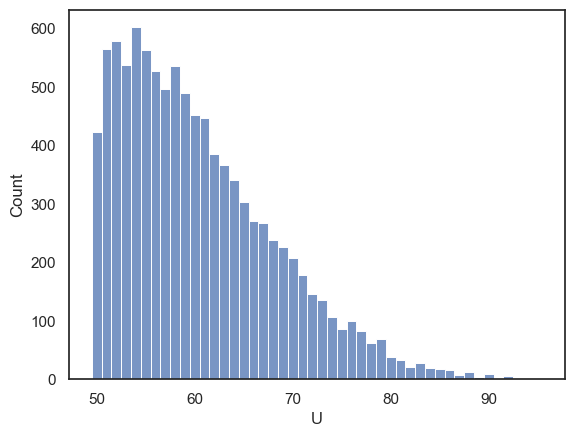

In [11]:
sns.histplot(results.null_distribution)
plt.xlabel('U')
plt.show()

The distribution is cut off at a minimum of 49.5, because $u$ is always the *larger* of the two rank sums (for the two groups). The minimum possible value of the larger ranksum (which would happen if the high and low ranks were evenly shared between groups) is 49.5

We can also verify that out $p$-value is the proportion of shuffles in which $U>=91$

In [12]:
np.mean(results.null_distribution>=91)

0.0006

Ta-daa!